In [1]:
import torch
from torch import nn
from torch.optim import SGD, Adam
from annpy.models.gan import GAN
from annpy.training import GANTrainer
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10
from torchtrainer.callbacks import ProgbarLogger
from torchtrainer.utils.data.datasets import UnsuperviseDataset
import matplotlib.pyplot as plt


WIDTH=32
HEIGHT=32
USE_CUDA=True

## Model ##

In [2]:
class Discriminator(nn.Module):
    """ GAN Model for generate MNIST digits """
    def __init__(self, last_act=None):
        super(Discriminator, self).__init__()

        self._filter = nn.Sequential(nn.Conv2d(in_channels=3, out_channels=32,kernel_size=5,padding=0,stride=1),
                                          nn.BatchNorm2d(32),
                                          nn.LeakyReLU(inplace=True),
                                          nn.Dropout(0.5),
                                          nn.MaxPool2d(2),
                                          nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1, stride=1),
                                          nn.BatchNorm2d(64),
                                          nn.LeakyReLU(inplace=True),
                                          nn.Dropout(0.5),
                                          nn.MaxPool2d(2))
                                          # nn.Dropout(0.5))
        self._classifier = nn.Sequential(nn.Linear(7*7*64, 1),
                                         nn.Dropout(0.2)
                                         )

    def forward(self, x):
        x = self._filter(x)
        x = x.view(x.shape[0], -1)
        x = self._classifier(x)
        return x

    @property
    def input_shape(self):
        return (1, 28, 28)

class Generator(nn.Module):
    """ GAN Model for generate MNIST digits """
    def __init__(self, last_act=None):
        super(Generator, self).__init__()
        self._layers = nn.Sequential(nn.ConvTranspose2d(in_channels=64, out_channels=128, kernel_size=10, stride=5, padding=0),
                                     nn.BatchNorm2d(128),
                                     nn.LeakyReLU(inplace=True),
                                     nn.Dropout(0.5),
                                     nn.ConvTranspose2d(in_channels=128, out_channels=256, kernel_size=6, stride=3, padding=1),
                                     nn.BatchNorm2d(256),
                                     nn.LeakyReLU(inplace=True),
                                     nn.Dropout(0.5),
                                     nn.ConvTranspose2d(in_channels=256, out_channels=3, kernel_size=2, stride=1, padding=0),
                                     nn.BatchNorm2d(3),
                                     # # nn.BatchNorm2d(1),
                                     nn.Sigmoid(),
                                     # nn.Dropout(0.2),
                                     )


    def forward(self, x):
        x = x.view(-1,64,1, 1)
        #print(self._layers(x).shape)
        return self._layers(x)
    
    @property
    def input_shape(self):
        return (64, )

In [3]:
gen = Generator()
dis = Discriminator()

In [4]:
gen

Generator(
  (_layers): Sequential(
    (0): ConvTranspose2d (64, 128, kernel_size=(10, 10), stride=(5, 5))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
    (2): LeakyReLU(0.01, inplace)
    (3): Dropout(p=0.5)
    (4): ConvTranspose2d (128, 256, kernel_size=(6, 6), stride=(3, 3), padding=(1, 1))
    (5): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
    (6): LeakyReLU(0.01, inplace)
    (7): Dropout(p=0.5)
    (8): ConvTranspose2d (256, 3, kernel_size=(2, 2), stride=(1, 1))
    (9): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True)
    (10): Sigmoid()
  )
)

In [5]:
dis

Discriminator(
  (_filter): Sequential(
    (0): Conv2d (3, 32, kernel_size=(5, 5), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True)
    (2): LeakyReLU(0.01, inplace)
    (3): Dropout(p=0.5)
    (4): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (5): Conv2d (32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    (7): LeakyReLU(0.01, inplace)
    (8): Dropout(p=0.5)
    (9): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1))
  )
  (_classifier): Sequential(
    (0): Linear(in_features=3136, out_features=1)
    (1): Dropout(p=0.2)
  )
)

In [6]:
m = GAN(discriminator=dis, generator=gen)

In [7]:
def showsample():
    im = m.sample(1).data[0]
    if USE_CUDA:
        im = im.cpu()
    plt.imshow(im.numpy().transpose(1, 2, 0))
    plt.colorbar()
    plt.show()

## Training ##

In [8]:
g_optimizer = Adam(m.generator.parameters(), lr=1e-2, weight_decay=0, betas=(0.5, 0.999))
d_optimizer = Adam(m.discriminator.parameters(), lr=1e-2, weight_decay=0, betas=(0.5, 0.999))

In [9]:
trainer = GANTrainer(m,
                     d_optimizer,
                     g_optimizer,
                     callbacks=[ProgbarLogger(notebook=True)],
                     logging_frecuency=50,
                     soft_labels_eps=0)

In [10]:
transform = transforms.Compose([transforms.Resize((WIDTH, HEIGHT)),
                                transforms.ToTensor()])

In [11]:
train_ds = UnsuperviseDataset(CIFAR10(root='data', download=True, train=True, transform=transform))
test_ds = UnsuperviseDataset(CIFAR10(root='data', download=False, train=False, transform=transform))

Files already downloaded and verified


In [12]:
train_ds[0].shape

torch.Size([3, 32, 32])

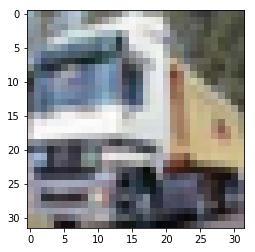

In [13]:
plt.imshow(train_ds[1].numpy().transpose(1, 2, 0))
plt.show()

In [14]:
dataloader = DataLoader(train_ds, batch_size=128)
test_dl = DataLoader(test_ds, batch_size=128)

In [15]:
if USE_CUDA:
    trainer.cuda()

In [16]:
trainer.train(dataloader,
              valid_dataloader=test_dl,
              epochs=10)

## Evaluating ##

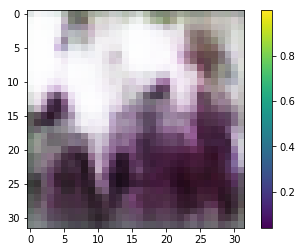

In [17]:
m.eval()
showsample()

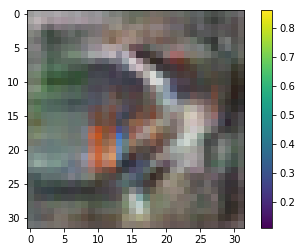

In [19]:
m.eval()
showsample()

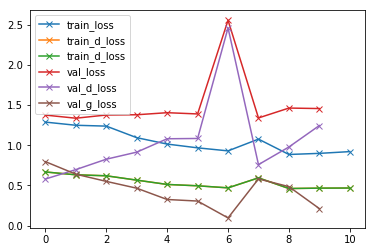

In [20]:
trainer.history.epoch_plot('train_loss')
trainer.history.epoch_plot('train_d_loss')
trainer.history.epoch_plot('train_d_loss')
trainer.history.epoch_plot('val_loss')
trainer.history.epoch_plot('val_d_loss')
trainer.history.epoch_plot('val_g_loss')
plt.legend()
plt.show()

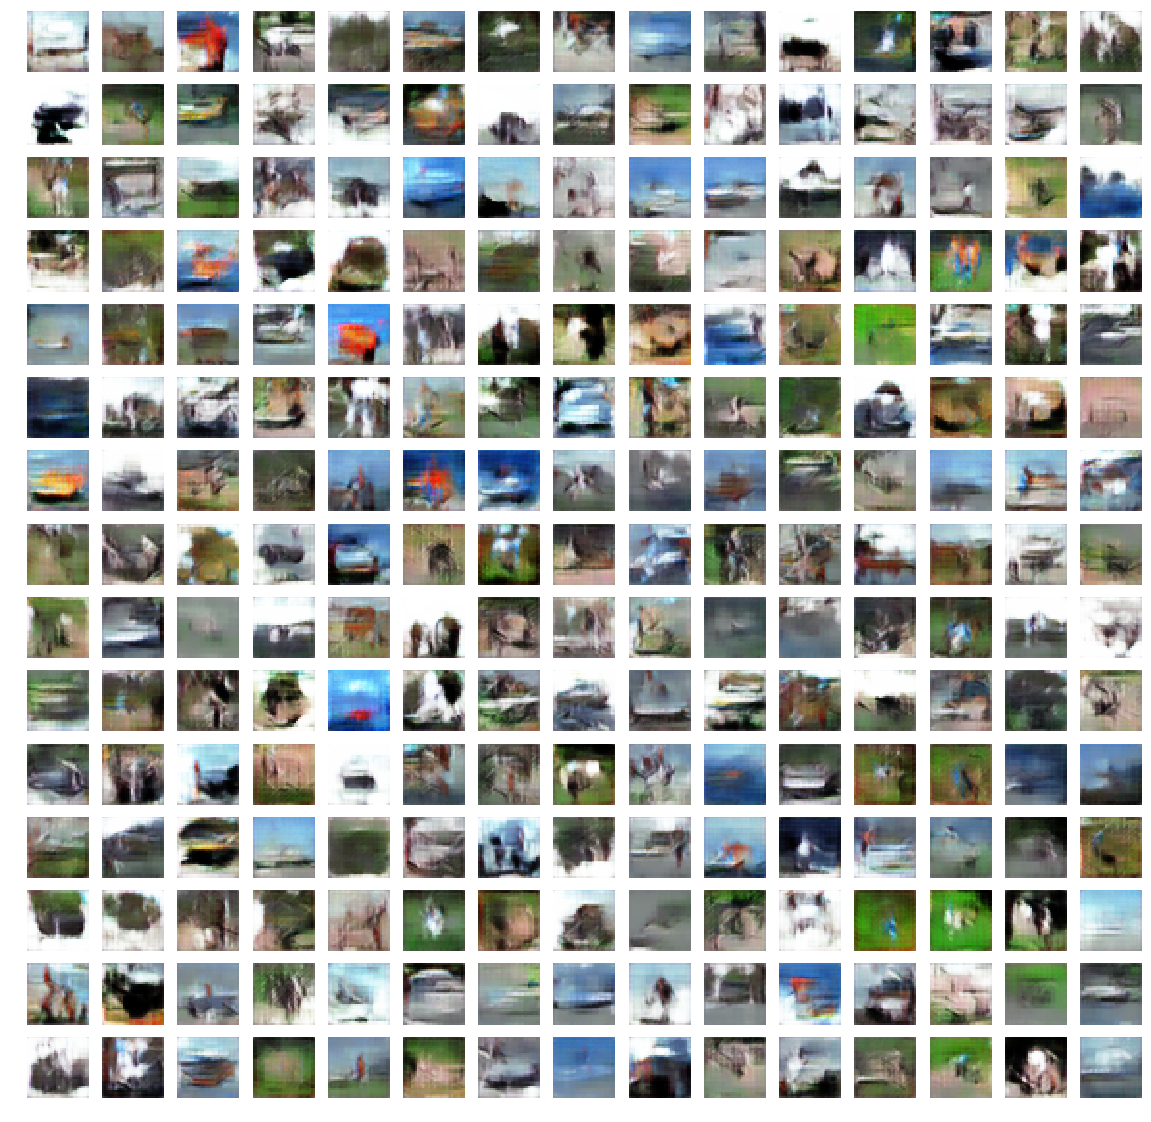

In [22]:
m.eval()
ROWS = 15
COLS = 15
fig = plt.figure(figsize=(20, 20))
ims = m.sample(ROWS*COLS).data.cpu().numpy().transpose(0,2,3,1)

for i in range(COLS*ROWS):
    sub = fig.add_subplot(COLS, ROWS, i+1)
    sub.imshow(ims[i], interpolation='nearest')
    sub.axis('off')
plt.savefig('output.jpg')
plt.show()